<a href="https://colab.research.google.com/github/Afnan1278/deep-learning/blob/master/FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

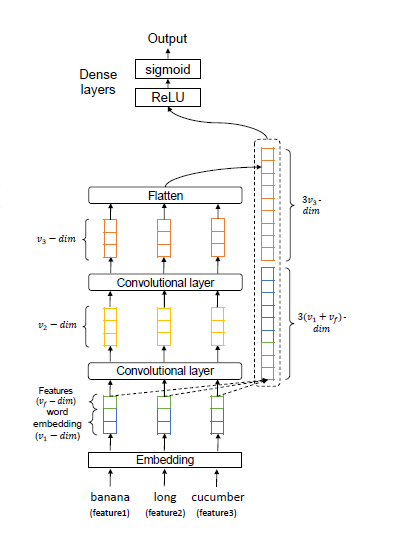

GluonNLP provides implementations of the state-of-the-art (SOTA) deep learning models in NLP, and build blocks for text data pipelines and models.

In [ ]:
!pip install gluonnlp
!pip install mxnet
import gluonnlp as nlp


---

---





GETTING THE GLOVE EMBEDDING FILE FROM GLUON

---

---


In [ ]:
glove = nlp.embedding.create('glove', source='glove.6B.300d')
glove['the']


[ 4.6560e-02  2.1318e-01 -7.4364e-03 -4.5854e-01 -3.5639e-02  2.3643e-01
 -2.8836e-01  2.1521e-01 -1.3486e-01 -1.6413e+00 -2.6091e-01  3.2434e-02
  5.6621e-02 -4.3296e-02 -2.1672e-02  2.2476e-01 -7.5129e-02 -6.7018e-02
 -1.4247e-01  3.8825e-02 -1.8951e-01  2.9977e-01  3.9305e-01  1.7887e-01
 -1.7343e-01 -2.1178e-01  2.3617e-01 -6.3681e-02 -4.2318e-01 -1.1661e-01
  9.3754e-02  1.7296e-01 -3.3073e-01  4.9112e-01 -6.8995e-01 -9.2462e-02
  2.4742e-01 -1.7991e-01  9.7908e-02  8.3118e-02  1.5299e-01 -2.7276e-01
 -3.8934e-02  5.4453e-01  5.3737e-01  2.9105e-01 -7.3514e-03  4.7880e-02
 -4.0760e-01 -2.6759e-02  1.7919e-01  1.0977e-02 -1.0963e-01 -2.6395e-01
  7.3990e-02  2.6236e-01 -1.5080e-01  3.4623e-01  2.5758e-01  1.1971e-01
 -3.7135e-02 -7.1593e-02  4.3898e-01 -4.0764e-02  1.6425e-02 -4.4640e-01
  1.7197e-01  4.6246e-02  5.8639e-02  4.1499e-02  5.3948e-01  5.2495e-01
  1.1361e-01 -4.8315e-02 -3.6385e-01  1.8704e-01  9.2761e-02 -1.1129e-01
 -4.2085e-01  1.3992e-01 -3.9338e-01 -6.7945e-02  

---




GETIING THE SPACY EMBEDDINGS

---


In [ ]:
!python -m spacy download en_core_web_lg



---

---
CREATING CUSTOM DATASET CLASS

---

---








In [ ]:
#importing important libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.utils import shuffle


import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import spacy



# loading the spacy embedding model
# nlp = spacy.load('en_core_web_lg')



# creating custom dataset class
class SemEval(Dataset):
    def __init__(self, df1):
        # df = pd.read_csv(r'/content/drive/MyDrive/fyp/classifier_adapt/train.csv')
        df = df1
        self.lines = df.drop(['lab'], axis=1)
        # print(self.lines)
        self.labels =np.asarray(df.drop(['text'], axis=1))
        # print(self.labels)
        self.to_tensor = transforms.ToTensor()
        self.data_len = len(self.lines)
        

    def __getitem__(self, index):
        lab = self.labels[index]
        data = np.asarray(self.lines.loc[index])
        g = data[0].split(' ')
        l1 = glove[g[0]].asnumpy()
        l2 = glove[g[1]].asnumpy()
        l3 = glove[g[2]].asnumpy()

        # text = str(data)[1:-1]
        # doc = nlp(text)
        # l1 = np.asarray(doc[0].vector)
        # l2 = np.asarray(doc[1].vector)
        # l3 = np.asarray(doc[2].vector)

        sl = np.vstack(((l1,l2,l3)))
        # print(sl.shape)

        t = self.to_tensor(sl)
        # print(t.shape)
        # print(sl)
        # print(lab)
        return (t, lab)

    def __len__(self):
        return len(self.lines.index)




---



---
CREATING NETWORK

---

---






In [ ]:
# creating network class        
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3)

        self.fc1 = nn.Linear(in_features=11700, out_features=6000)
        self.fc2 = nn.Linear(in_features=6000, out_features=2800)
        self.fc3 = nn.Linear(in_features=2800, out_features=1400)
        self.fc4 = nn.Linear(in_features=1400, out_features=120)
        # self.fc5 = nn.Linear(in_features=700, out_features=500)
        # self.fc6 = nn.Linear(in_features=500, out_features=300)
        # self.fc7 = nn.Linear(in_features=300, out_features=120)
        self.fc8 = nn.Linear(in_features=120, out_features=10)
        self.out = nn.Linear(in_features=10, out_features=2)

    def forward(self, t):
        # (1) input layer
        t = t
        res = t
        # print("input layer", t.shape)
        # (2) hidden conv layer
        p = nn.ZeroPad2d(1)
        t = p(t)
        # print("after conv1 padding", t.shape)
        t = self.conv1(t)
        # print("after conv1 layer", t.shape)
        t = F.relu(t)
        # print("after conv1 activation", t.shape)

        # t = F.max_pool2d(t, kernel_size=2, stride=2)
        # print("after conv1 maxPooling", t.shape)


        # (3) hidden conv layer
        p = nn.ZeroPad2d(1)
        t = p(t)
        # print("after conv2 padding", t.shape)
        t = self.conv2(t)
        # print("after conv2 layer", t.shape)
        t = F.relu(t)
        # print("after conv2 activation", t.shape)


        # t = F.max_pool2d(t, kernel_size=2, stride=2)
        # print("after conv2 maxPooling", t.shape)

        # (4) hidden linear layer
        t = t.reshape(-1,12 * 3 * 300)
        # res = res.flatten()
        # res.unsqueeze(dim = 0)
        # print(t.shape)        
        # t = torch.cat([t, res]).view(-1)
        # print("res shape", res.shape)
        res = res.reshape(-1 , 900)
        t = torch.cat((t,res),1)
        # print(res.shape)
        # print('first linear layer', t.shape)
        t = self.fc1(t)
        # print("after fc1", t.shape)
        t = F.relu(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)

         # (6) hidden linear layer
        t = self.fc3(t)
        t = F.relu(t)

         # (7) hidden linear layer
        t = self.fc4(t)
        t = F.relu(t)

        #  # (8) hidden linear layer
        # t = self.fc5(t)
        # t = F.relu(t)

        #  # (9) hidden linear layer
        # t = self.fc6(t)
        # t = F.relu(t)

        #  # (10) hidden linear layer
        # t = self.fc7(t)
        # t = F.relu(t)

        # (11) hidden linear layer
        t = self.fc8(t)
        t = F.relu(t)

        # (12) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1)     
        return t




---

---
TRAINING & SAVING MODEL

---



---






In [ ]:
# funtion for getting the number of correct outcomes
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()



# saving the model
def save_checkpoint(state, filename = "/content/drive/MyDrive/fyp/classifier_adapt/my_checkpoint.pth.tar"):
    print('saving model')
    torch.save(state, filename)


#training the model
def run():

    df = pd.read_csv(r'/content/drive/MyDrive/fyp/classifier_adapt/train.csv')
    df_majority = df[df.lab==0]
    df_minority = df[df.lab==1]

    # df_majority_downsampled = resample(df_majority, 
    #                              replace=False,    # sample without replacement
    #                              n_samples=6362,     # to match minority class
    #                              random_state=123) # reproducible resul


    # df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    # df_downsampled.reset_index(drop=True)
    # df_downsampled = df_downsampled.sample(frac=1).reset_index(drop=True)


    df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples=11185,     # to match majority class
                                 random_state=123) # reproducible resul


    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    df_upsampled.reset_index(drop=True)
    df_upsampled = df_upsampled.sample(frac=1).reset_index(drop=True)    

    print(df)
    train_set = SemEval(df)
    # sample = next(iter(train_set))
    # s, i =sample
    # print(s.unsqueeze(0).shape)
    network = Network()
    print("hello")
    # print(network.conv1.weight.shape)
    # pred = network(s.unsqueeze(0))
    # print (pred)



    
    optimizer = optim.Adam(network.parameters(), lr=0.01)
    train_loader = torch.utils.data.DataLoader(
        train_set
        ,batch_size=100
        ,shuffle=True
        )
    
    for epoch in range(5):

        total_loss = 0
        total_correct = 0

        for batch in train_loader: 
            text, labels = batch 
            labels = labels.reshape(-1,)
            preds = network(text) 
            loss = F.cross_entropy(preds, labels) 

            optimizer.zero_grad()
            loss.backward() 
            optimizer.step() 

            total_loss += loss.item()
            total_correct += get_num_correct(preds, labels)

        print(
            "epoch", epoch, 
            "total_correct:", total_correct, 
            "loss:", total_loss
        )

    checkpoint = {'state_dict': network.state_dict()}
    save_checkpoint(checkpoint)
    print(network.conv1.weight)

run()

       lab                      text
0        0         goose duck sticky
1        0  banjo harmonica stations
2        1      mushroom onions stem
3        0  lime cucumber recyclable
4        0         pot potato helium
...    ...                       ...
17542    0    lantern chandelier lid
17543    0   camisole dress straight
17544    1     catfish perch garbage
17545    0        train truck prongs
17546    0        tuna garlic things

[17547 rows x 2 columns]
hello
after conv2 activation torch.Size([100, 12, 3, 300])
after conv2 activation torch.Size([100, 12, 3, 300])
after conv2 activation torch.Size([100, 12, 3, 300])
after conv2 activation torch.Size([100, 12, 3, 300])
after conv2 activation torch.Size([100, 12, 3, 300])
after conv2 activation torch.Size([100, 12, 3, 300])
after conv2 activation torch.Size([100, 12, 3, 300])
after conv2 activation torch.Size([100, 12, 3, 300])
after conv2 activation torch.Size([100, 12, 3, 300])
after conv2 activation torch.Size([100, 12, 3, 



---

---
LOADING AND TESTING MODEL

---

---








In [ ]:
#loading the model
def load_checkpoint(model, checkpoint):
    print('loading checkpoint')
    model.load_state_dict(checkpoint['state_dict'])
    return model
    
# funtion for getting the number of correct outcomes
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

# model prediction on giving samples
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        print(images.shape)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

def test():

  df = pd.read_csv(r'/content/drive/MyDrive/fyp/classifier_adapt/validation.csv')
  test_set = SemEval(df)
  labels =np.asarray(df.drop(['text'], axis=1)) 
  labels = labels.flatten()
  # print(len(labels))
  labs = torch.Tensor(labels)
  model = Network()
  model = load_checkpoint(model, torch.load('/content/drive/MyDrive/fyp/classifier_adapt/my_checkpoint.pth.tar'))
  # print(model.conv1.weight)
  with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(test_set, batch_size=100)
    test_preds = get_all_preds(model, prediction_loader)
  print(labs)
  preds_correct = get_num_correct(test_preds, labs)

  print('total correct:', preds_correct)

test()

loading checkpoint
after conv2 activation torch.Size([100, 12, 3, 300])
torch.Size([100, 1, 3, 300])
after conv2 activation torch.Size([100, 12, 3, 300])
torch.Size([100, 1, 3, 300])
after conv2 activation torch.Size([100, 12, 3, 300])
torch.Size([100, 1, 3, 300])
after conv2 activation torch.Size([100, 12, 3, 300])
torch.Size([100, 1, 3, 300])
after conv2 activation torch.Size([100, 12, 3, 300])
torch.Size([100, 1, 3, 300])
after conv2 activation torch.Size([100, 12, 3, 300])
torch.Size([100, 1, 3, 300])
after conv2 activation torch.Size([100, 12, 3, 300])
torch.Size([100, 1, 3, 300])
after conv2 activation torch.Size([100, 12, 3, 300])
torch.Size([100, 1, 3, 300])
after conv2 activation torch.Size([100, 12, 3, 300])
torch.Size([100, 1, 3, 300])
after conv2 activation torch.Size([100, 12, 3, 300])
torch.Size([100, 1, 3, 300])
after conv2 activation torch.Size([100, 12, 3, 300])
torch.Size([100, 1, 3, 300])
after conv2 activation torch.Size([100, 12, 3, 300])
torch.Size([100, 1, 3, 300



---

---
INTERACTIVE TESTING

---

---








In [ ]:
import spacy

# loading the spacy embedding model
# nlp = spacy.load('en_core_web_lg')
to_tensor = transforms.ToTensor()

# model = Network()
model = load_checkpoint(model, torch.load('/content/drive/MyDrive/fyp/classifier_adapt/my_checkpoint.pth.tar'))
triplets = input()
arr = triplets.split(' ')
# print(arr)
# doc = nlp(triplets)
l1 = glove[arr[0]].asnumpy()
l2 = glove[arr[1]].asnumpy()
l3 = glove[arr[2]].asnumpy()
sl = np.vstack(((l1,l2,l3)))
t = to_tensor(sl)
# print(t.shape)
pred = model(t.unsqueeze(0))
pred = F.softmax(pred, dim=1).argmax(dim=1)
if (pred[0]==1):
  print("discrimnatory")
else:
  print("not discriminatory")


loading checkpoint
goose duck sticky
after conv2 activation torch.Size([1, 12, 3, 300])
not discriminatory
